Source: https://www.opentopodata.org

In [1]:
import requests
import shapely
import numpy as np
import pandas as pd

from lets_plot import *
from lets_plot.geo_data import *

The geodata is provided by © OpenStreetMap contributors and is made available here under the Open Database License (ODbL).


In [2]:
def update_data(data, x, y, lon, lat, elevation, warning=None, print_warning=False):
    if print_warning and warning is not None:
        print("({0}, {1}): {2}".format(lat, lon, warning))
    data["x"].append(x)
    data["y"].append(y)
    data["lon"].append(lon)
    data["lat"].append(lat)
    data["elevation"].append(elevation)
    return data

data = {"x": [], "y": [], "lon": [], "lat": [], "elevation": []}

In [3]:
PRINT_WARNING = False

country_name = "New Zealand"
file_name = "new_zealand-dem.csv"
crop_rect = shapely.Polygon([(150, -48), (150, 0), (180, 0), (180, -48)])

url = lambda lat, lon: "https://api.opentopodata.org/v1/nzdem8m?locations={0},{1}".format(lat, lon)
n, m = 200, 75

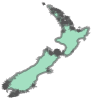

In [4]:
original_geometry = geocode_countries(country_name).inc_res(4).get_boundaries().iloc[0].geometry
geometry = original_geometry.intersection(crop_rect)
geometry

In [5]:
bounds = geometry.bounds
bounds

(166.4208984375, -47.2866818887642, 178.5498046875, -34.1436348203126)

In [6]:
for x, lon in enumerate(np.linspace(bounds[0], bounds[2], n)):
    for y, lat in enumerate(reversed(np.linspace(bounds[1], bounds[3], m))):
        p = shapely.Point(lon, lat)
        if not geometry.contains(p):
            data = update_data(data, x, y, lon, lat, None, "Out of the area", PRINT_WARNING)
            continue
        response = requests.get(url(lat, lon))
        if not response.ok:
            data = update_data(data, x, y, lon, lat, None, "Response is not OK", PRINT_WARNING)
            continue
        json = response.json()
        if json['status'] != "OK":
            data = update_data(data, x, y, lon, lat, None, "JSON is not OK", PRINT_WARNING)
            continue
        elevation = json["results"][0]["elevation"]
        if elevation is None:
            data = update_data(data, x, y, lon, lat, None, "Elevation is None", PRINT_WARNING)
            continue
        data = update_data(data, x, y, lon, lat, elevation)

df = pd.DataFrame(data)
print(df.shape)
df.head()

(15000, 5)


,x,y,lon,lat,elevation
0,0,0,166.420898,-34.143635,NaN
1,0,1,166.420898,-34.321244,NaN
2,0,2,166.420898,-34.498852,NaN
3,0,3,166.420898,-34.676461,NaN
4,0,4,166.420898,-34.854070,NaN


In [7]:
dem_df = df.pivot(index='y', columns='x', values='elevation').fillna(0.0)
print(dem_df.shape)
dem_df.head()

(75, 200)


x,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
y,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
dem_df.to_csv(file_name, header=False, index=False)